# Museums in the Pandemic - Extract indicators

**Authors**: Andrea Ballatore (KCL)

**Abstract**: Extract indicators from museum text. The indicators are generated from the app with option `an_text`.

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [55]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'mip_v1':
    raise Exception("Set the environment 'mip_v1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import pandas as pd
import pickle
import random
import glob
import spacy
print(spacy.__version__)
from termcolor import colored
import sys
import numpy as np
from numpy import arange
#import tensorflow as tf
from bs4 import BeautifulSoup
from bs4.element import Comment
from datetime import datetime
import seaborn as sns
#import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap, TwoSlopeNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator
from matplotlib.dates import DateFormatter, MonthLocator, YearLocator


# import from `mip` project
print(os.getcwd())
fpath = os.path.abspath('../')
if not fpath in sys.path:
    sys.path.insert(0, fpath)

out_folder = '../../'

from museums import *
from museums import get_museums_w_web_urls, get_twitter_facebook_links, load_input_museums_wattributes, get_extra_museum_attributes
from utils import _is_number, write_file
from analytics.text_models import derive_new_attributes_matches, get_all_matches_from_db, get_indicator_annotations, derive_new_attributes_matches
from scrapers.scraper_websites import get_scraping_session_tables, get_session_id_from_table_name
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score


def format_xaxis_month_year():
    """ Format X axis for temporal data with Year/Month grid lines  """
    ax = plt.gca()
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(MonthLocator())
    ax.xaxis.set_minor_formatter(DateFormatter('%b'))
    #plt.xticks(rotation=0, horizontalalignment='right') 
    plt.grid(b=True, which='major', color='gray', linestyle='-')
    plt.grid(b=True, which='minor', color='lightgray', linestyle='--')


print('env ok')

Conda env: mip_v1
2.3.5
/Users/andreaballatore/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/notebooks_py
env ok


## Connect to DB

It needs the DCS VPN active to work.

In [13]:
# open connection to DB
from db.db import connect_to_postgresql_db

db_conn = connect_to_postgresql_db()
print("DB connected")

def get_all_sessions():
    return sorted([get_session_id_from_table_name(x) for x in get_scraping_session_tables(db_conn)])

DB connected


## Extract matches for all museum websites

Using the best deep learning model defined above, find indicators for all museums (from websites and social media).

The manual annotation data with 700 cases is in `matches_valid_ann_df_v3.pik`.

### Load deep learning validation model

In [18]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

def remove_duplicate_matches(df):
    # find duplicates
    n = len(df)
    df = df.drop_duplicates(subset=df.columns.difference(['page_id','sentence_id']))
    print('remove_duplicate_matches:',n,len(df))
    return df

def prep_match_data(df):
    for c in valid_model_columns:
        if not c in df.columns:
            print("Warning: column '{}' is missing, adding a zero column".format(c))
            df[c] = 0
    
    df = remove_duplicate_matches(df)
    df = df[valid_model_columns]
    assert len(df.columns) == 33, len(df.columns)
    num_df = df.select_dtypes(include=[np.number])
    scaler = MinMaxScaler()
    # fit and transform in one step
    cols = num_df.columns
    x_data = pd.DataFrame(scaler.fit_transform(num_df),columns=cols)
    return x_data

def convert_pred_to_bool(vals):
    pred_y = (vals > 0.5).astype("bool")
    # unpack results
    bool_vals = [item for sublist in pred_y for item in sublist]
    return bool_vals

In [19]:
# MODEL COLUMNS
cols_fn = out_folder+"data/analysis/matching_validation/matching_validation_deep_learning_model_columns.csv"
valid_model_columns = pd.read_csv(cols_fn).iloc[:, 0].tolist()

valid_ann_df_fn = 'matches_valid_ann_df_v3.pik'
valid_ann_df = pd.read_pickle(out_folder+'data/annotations/'+valid_ann_df_fn)

valid_match_cnn_model = load_model(out_folder+"data/analysis/matching_validation/matching_validation_deep_learning_model.h5")
valid_match_cnn_model

x_data = prep_match_data(valid_ann_df)
assert len(x_data.columns) == 33, len(x_data.columns)
print(x_data)
pred_valid = convert_pred_to_bool(valid_match_cnn_model.predict(x_data))

valid_ann_df['predicted_valid'] = pred_valid

#valid_ann_df.to_excel(out_folder+"tmp/check_deeplearning.xlsx",index=False)
valid_ann_df.sample(5)

2022-06-23 15:07:13.326469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-23 15:07:13.480954: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


remove_duplicate_matches: 700 700
     sem_similarity   token_n   lemma_n  ann_overlap_lemma  ann_overlap_token  \
0          0.659748  0.285714  0.166667           1.000000            1.00000   
1          0.703680  0.428571  0.333333           0.733333            0.75000   
2          0.759582  0.000000  0.000000           0.146667            0.00000   
3          0.726219  0.571429  0.500000           0.644448            0.66667   
4          0.667261  0.000000  0.000000           0.200000            0.00000   
..              ...       ...       ...                ...                ...   
695        0.830129  0.428571  0.333333           0.573333            0.60000   
696        0.712849  0.142857  0.166667           1.000000            0.50000   
697        0.398828  0.000000  0.000000           0.200000            0.00000   
698        0.647905  0.000000  0.000000           0.200000            0.00000   
699        0.661403  0.142857  0.000000           0.288885            0.333

,muse_id,page_id,sentence_id,example_id,indicator_code,session_id,ann_ex_tokens,page_tokens,sem_similarity,token_n,...,indicator_code_project_postpone,indicator_code_reopen_intent,indicator_code_reopen_plan,indicator_code_staff_hiring,indicator_code_staff_restruct,indicator_code_staff_working,overlap_bin,valid_match,valid_match_b,predicted_valid
252,mm.mgs.367,447911,mus_page447911_sent00029,ann_ex_00059,funding_did_not_get,20210304,charity we receive no core government funding,news trees future posted news funding award mu...,0.7275,1,...,0,0,0,0,0,0,"(0.0, 0.45]",F,False,False
28,mm.domus.SC176,773627,mus_page773627_sent00064,ann_ex_00221,reopen_intent,20210304,updates reopening,however we beginning to reopen our grounds car...,0.4465,0,...,0,1,0,0,0,0,"(0.45, 1.01]",T,True,False
405,mm.domus.NW027,249004,mus_page249004_sent00146,ann_ex_00006,closed_cur,20210304,currently we closed covid restrictions,car park mill shop closed wednesday,0.5984,1,...,0,0,0,0,0,0,"(0.0, 0.45]",F,False,False
573,mm.domus.SE153,273628,mus_page273628_sent00011,ann_ex_00190,online_exhib,20210304,online collection,tiger squadron museum appeal usaaf 458th bg sh...,0.6408,1,...,0,0,0,0,0,0,"(0.45, 1.01]",F,False,False
576,mm.domus.SE461,298717,mus_page298717_sent00083,ann_ex_00195,open_cafe,20210304,our cafe open,old school cafe light lunches drinks snacks he...,0.7720,1,...,0,0,0,0,0,0,"(0.0, 0.45]",F,False,False


In [ ]:
def aggr_indicators_by_indic(df):
    d = {}
    for c in ['indicator_code']:
        d[c] = df[c].tolist()[0]
    d['cases_700'] = len(df)
    d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    if len(confmat)>1:
        d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    for k,v in d.items():
        d[k] = [v]
        
    res = pd.DataFrame.from_dict(d)
    return res

# extract indicator stats
#indf2 = valid_ann_df.indicator_code.value_counts().to_frame('valid_set_700_cases')
#indf2['indicator_code'] = indf2.index
#indf2

indf2 = pd.DataFrame()
for indic,subdf in valid_ann_df.groupby('indicator_code'):
    indf2 = indf2.append(aggr_indicators_by_indic(subdf))
indf2 = indf2.round(3)
indf2

### Load all matches from DB (slow)

- Dump all matches from DB, after running `an_text` on ALL museums for a given crawling session.

In [ ]:
# DB columns:
""" 
example_id indicator_code lemma_n lemma_n_wdupl token_n token_n_wdupl criticalwords_n criticalwords_n_wdupl sentence_id  sent_len
example_len example_crit_len ann_overlap_lemma ann_overlap_token ann_overlap_criticwords txt_overlap_lemma
txt_overlap_token ann_ex_tokens ann_ex_tokens page_tokens session_id page_id muse_id keep_stopwords
"""
sessions = get_all_sessions()
sessions = ['20210304','20210404','20210629','20210914','20210503','20210614','20210712','20210809','20211108']
sessions.extend(['20211206','20220103','20220131','20220228','20220328','20220425','20220524']) # 2022 sessions
sessions = sorted(sessions)
print("target sessions:", sessions)

# get all sessions from DB (slow)
if False: # debug
    for session_id in sessions:
        get_all_matches_from_db(session_id, db_conn, out_folder)
        

## Predict and save valid matches

Load matches from `../../tmp/matches_dump_df_<session>.pik`

Dump results in file `../../tmp/all_valid_matches_dump_df.pik`

In [21]:
#sessions = ['20210304','20210404']

def select_and_merge_indicators(df):
    """ based on `indicator_code_stats_validation-v2.xlsx` """
    print('select_and_merge_indicators',df.shape)
    # drop invalid indicators
    invalid_indics = ['closed_perm','finance_health','funding_did_not_get',
                     'funding_other_emer','lang_difficulty','made_covid_safe',
                     'open_cafe','open_onlineshop','project_postpone',
                      'staff_hiring','staff_restruct']
    vdf = df[~df['indicator_code'].isin(invalid_indics)].copy()
    
    # merge indicators
    merged_indic = {'online_event':'online_engag',
                    'online_exhib':'online_engag',
                    'reopen_plan':'reopen_intent',
                    'funding_fundraise':'funding',
                    'funding_gov_emer':'funding',
                    'closed_indef':'closed_cur'}
    indicator_code_merged = vdf['indicator_code'].replace(merged_indic)
    vdf.loc[:,['indicator_code_merged']]=indicator_code_merged
    # compare results
    print(df['indicator_code'].value_counts())
    print(vdf['indicator_code_merged'].value_counts())
    print('  select_and_merge_indicators filtered:',vdf.shape)
    return vdf

def select_valid_matches(df, model):
    """ use Deep Learning model to validate matches """
    x_data = prep_match_data(df)
    
    print('select_valid_matches', x_data.shape)
    # check column order
    assert valid_model_columns == x_data.columns.tolist()
    print(x_data.shape)
    # apply model for predictions
    valid_int = model.predict(x_data)
    pred_valid = convert_pred_to_bool(valid_int)
    #print(type(pred_valid),len(pred_valid))
    df['valid_match'] = pred_valid
    print(df.valid_match.value_counts())
    return df

In [ ]:
assert len(valid_model_columns) > 0
allsess_match_df = pd.DataFrame(columns=valid_model_columns)

print('sessions:', sessions)
for session_id in sessions:
    print('\n> session_id',session_id)
    matches_fn = out_folder+'tmp/matches_dump_df_{}.pik'.format(session_id)
    matchdf = pd.read_pickle(matches_fn)
    matchdf = remove_duplicate_matches(matchdf)
    #matchdf = matchdf.sample(100) # DEBUG
    print("\t", matches_fn, matchdf.shape)
    # apply model to get valid matches
    validmatch_df = select_valid_matches(matchdf, valid_match_cnn_model)
    # save sample to inspect results
    #validmatch_df.sample(200).to_csv(out_folder+'tmp/valid_matches_sample_{}.tsv'.format(session_id),sep='\t')
    # save results
    allsess_match_df = pd.concat([allsess_match_df, validmatch_df])
    del validmatch_df

print('...merging indicators...')
allsess_match_df2 = select_and_merge_indicators(allsess_match_df)
print('...removing duplicates...')
allsess_match_df2 = remove_duplicate_matches(allsess_match_df2)
all_vmatches_fn = out_folder+'tmp/all_valid_matches_dump_df.pik'
print("valid matches vs invalid\n", allsess_match_df2.valid_match.value_counts())
print("sessions\n", allsess_match_df2.session_id.value_counts())
valdf = allsess_match_df2[allsess_match_df2.valid_match]
valdf.to_pickle(all_vmatches_fn)
print('valid matches for all sessions:', len(valdf), all_vmatches_fn)

In [ ]:
len(allsess_match_df)
allsess_match_df['valid_match'].value_counts()

In [ ]:
print(allsess_match_df.columns)
print("Matches from DB:")
round(allsess_match_df['valid_match'].value_counts()/len(allsess_match_df),2)

## [Aggregate indicators for extra evaluation]

This section extends and finalises the validation in notebook 01.

### Basic stats

In [ ]:
assert len(allsess_match_df) > 0
allsess_match_valid_df = allsess_match_df[allsess_match_df.valid_match]
allsess_match_valid_df = remove_duplicate_matches(allsess_match_valid_df)
print("N =", len(allsess_match_valid_df))
print("N museums =", len(allsess_match_valid_df.muse_id.unique()))
allsess_match_valid_df.head(100)

In [ ]:
# load annotations
indic_df, ann_df = get_indicator_annotations(out_folder)
del indic_df
# calculate n_indic_all_ann_examples
ann_stats_df = ann_df.groupby(['indicator_code']).size().reset_index(name='n_indic_all_ann_examples')
print(ann_df.head(30))
ann_stats_df

### Calculate precision of matching by indicator

This is to evaluate the performance by indicator to account for the high variability, as suggested by AP. 

- The results are in `indicator_code_stats_validation-v1.xlsx`. 
- Some indicators were removed.
- An extra evaluation was designed.

In [ ]:
# get indicator stats

def aggr_indicators_by_indic_allmatches(df):
    d = {}
    for c in ['indicator_code']:
        d[c] = df[c].tolist()[0]
    d['matches_ml_true'] = len(df)
    d['matches_ml_tot'] = len(allsess_match_df)
    d['matches_ml_pc'] = round(d['matches_ml_true'] / d['matches_ml_tot'],3)
    d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    if len(confmat)>1:
        d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    for k,v in d.items():
        d[k] = [v]
        
    res = pd.DataFrame.from_dict(d)
    return res

In [ ]:
indf3 = pd.DataFrame()
for indic,subdf in allsess_match_df.groupby('indicator_code'):
    indf3 = indf3.append(aggr_indicators_by_indic_allmatches(subdf))

indf3 = indf3.reset_index()
indf3 = indf3.merge(indf2,on='indicator_code',how='outer')
indf3 = indf3.merge(ann_stats_df,on='indicator_code',how='outer')
indf3.to_excel(out_folder+'tmp/indicator_code_stats_validation.xlsx',index=False)
indf3

Aggregate indicator stats by sentence.

In [ ]:
col_aggr = ['muse_id','session_id','page_id','indicator_code','n_indic_all_ann_examples']

def aggr_indicators_sent(df):
    d = {}
    for c in col_aggr:
        d[c] = df[c].tolist()[0]
    d['n_uniq_sentences'] = df['sentence_id'].nunique()
    d['n_matched_annotations'] = df['example_id'].nunique()
    d['n_matches'] = len(df)
    d['matches_to_sent_ratio'] = round(d['n_matches'] / d['n_uniq_sentences'],3)
    d['matches_to_example_ratio'] = round(d['n_matches'] / d['n_indic_all_ann_examples'],3)
    #d['matches_ratio'] = round(d['n_matches'] / d['n_indic_all_ann_examples'],3)
    return pd.Series(d)

n = len(allsess_match_valid_df)
allsess_match_valid_df2 = allsess_match_valid_df.merge(ann_stats_df, on='indicator_code')
assert n == len(allsess_match_valid_df2)

muse_indic_sent_df = allsess_match_valid_df2.groupby(col_aggr).apply(aggr_indicators_sent)
print(muse_indic_sent_df.columns)
muse_indic_sent_df.reset_index(drop=True, inplace=True)
muse_indic_sent_df = muse_indic_sent_df.sort_values(['session_id','muse_id','indicator_code'])
#print(muse_indic_sent_df.session_id.value_counts())
muse_indic_sent_df.to_excel(out_folder+'tmp/museum_indicators_sent_stats-v1.xlsx', index=False)
muse_indic_sent_df.head(30)

### Museum indic matches sample for extra validation - v1

Annotations done in `museum_website_match_sample10_summary-v1.xlsx`

In [ ]:
musem_sample_ids = muse_indic_sent_df.muse_id.sample(10,random_state=10)
muse_sample_df = muse_indic_sent_df[muse_indic_sent_df.muse_id.isin(musem_sample_ids)]
muse_sample_df.to_excel(out_folder+'tmp/museum_website_match_sample10_summary.xlsx',index=False)
allsess_match_valid_df[allsess_match_valid_df.muse_id.isin(musem_sample_ids)].to_excel(out_folder+'tmp/museum_website_match_sample10_matches.xlsx',index=False)

muse_sample_df

### Museum indic matches sample for extra validation - v2

- Select random sample from museums where matches > 0, 5 museums for 2 snapshots, for cases that need more investigation in `indicator_code_stats_validation-v1`
- Indicators to include: finance_health, lang_difficulty, staff_working
- Finance_health appears only in 2 museums, so we will discard it.
- The sample is in
  - `museum_website_match_sample5_lang_staff_summary-v1.xlsx`: stats for the 10 museums.
  - `museum_website_match_sample5_lang_staff-v1.xlsx`: sample of 200 detailed matches.
  
- The manual annotations are in `museum_website_match_sample5_lang_staff-v2.xlsx` and `museum_website_match_sample5_lang_staff_summary-v2.xlsx`.

In [ ]:
assert len(allsess_match_valid_df) > 0
assert len(allsess_match_df) > 0

print('allsess_match_valid_df N =',len(allsess_match_valid_df))

df = allsess_match_valid_df[['muse_id','indicator_code']].drop_duplicates()
muse_indic_df = df['indicator_code'].value_counts()
print(muse_indic_df)
del df

random.seed(422)

res = pd.DataFrame()
res_all = pd.DataFrame()
for indic in ['lang_difficulty', 'staff_working']:
    print('\n>> indicator:', indic)
    mus_df = allsess_match_valid_df[allsess_match_valid_df['indicator_code'] == indic]
    mus_df2 = allsess_match_df[allsess_match_df['indicator_code'] == indic]
    mus_ids = random.sample(list(mus_df.muse_id.unique()), 5)
    print(mus_ids)
    # get sample for annotation
    sample_df = mus_df2[mus_df2.muse_id.isin(mus_ids)]
    print(len(sample_df))
    print(sample_df.valid_match.value_counts())
    #if indic == 'lang_difficulty':
    #    df1 = sample_df[sample_df.valid_match]
    #    neg_df = sample_df[sample_df.valid_match==False]
    #    print('XXX', len(neg_df), len(df1))
    #    df1.append(neg_df.sample(92))
    #else:
    df1 = sample_df.sample(100)
    
    res_all = res_all.append(sample_df)
    print('\nSample', len(df1), df1.valid_match.value_counts())
    print(df1['muse_id'].unique())
    print(df1['session_id'].unique())
    res = res.append(df1)
    del df1, mus_df2

# add stats
res_all = res_all.merge(ann_stats_df,on='indicator_code')

# generate detailed results
res.to_excel(out_folder+'tmp/museum_website_match_sample5_lang_staff.xlsx',index=False)

In [ ]:
# generate summary
res_all
print(col_aggr)
df3 = res_all.groupby(col_aggr).apply(aggr_indicators_sent)
df3.to_excel(out_folder+'tmp/museum_website_match_sample5_lang_staff_summary.xlsx',index=False)
del df3

#### Calculating precision of extra validation

In [ ]:
# load extra validation for language_difficulty and staff_working
vdf = pd.read_excel(out_folder+'data/annotations/museum_website_match_sample5_lang_staff-v2.xlsx')
print(len(vdf))

vdf['predicted_valid'] = vdf.valid_match
vdf['valid_match_b'] = vdf['valid_PW'].map({'T': True, 'F': False})
vdf

In [ ]:
indf4 = pd.DataFrame()
for indic,df in vdf.groupby('indicator_code'):
    d = {}
    for c in ['indicator_code']:
        d[c] = df[c].tolist()[0]
    d['cases_700'] = len(df)
    print(df.columns)
    d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    if len(confmat) > 1:
        d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    for k,v in d.items():
        d[k] = [v]
        
    res = pd.DataFrame.from_dict(d)
    indf4 = indf4.append(res)

indf4 = indf4.reset_index()
indf4

In [ ]:
sum_df = pd.read_excel(out_folder+'data/annotations/museum_website_match_sample10_summary-v1.xlsx')
sum_df['valid'] = sum_df['2nd Validator (ap)'].map({'T': True, 'F': False})
print(len(sum_df))

indf2 = pd.DataFrame()
for indic, df in sum_df.groupby('indicator_code'):
    d = {'indicator_code': indic}
    d['cases_n'] = len(df)
    #print(df.columns)
    #d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    #confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    #if len(confmat) > 1:
    #    d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    tdf = df[df['valid']]
    fdf = df[~df['valid']]
    d['cases_true'] = len(tdf)
    d['cases_false'] = len(fdf)
    d['indic_mus_accuracy'] = d['cases_true']/d['cases_n']
    for k,v in d.items():
        d[k] = [v]
    res = pd.DataFrame.from_dict(d).round(2)
    indf2 = indf2.append(res)

# add extra validation
#Staff_working	6	2	75%
#Language_of_difficulty	6	3	67%

indf2 = indf2.append(pd.DataFrame({'indicator_code':['lang_difficulty'], 'indic_mus_accuracy':[.67]}))

indf2 = indf2.sort_values('indicator_code').reset_index()
indf2.to_excel(out_folder+'tmp/indicator_code_stats_validation-v3.xlsx',index=False)
indf2

### Extra validation social media indicators - 14 Jan 2022

File annotated by AP and PW to make sure social media indicators are identified correctly.

In [ ]:
eval_fn = out_folder+'data/analysis/indicators_social/valid_social_matches_dump_df_valid_debug-v3.xlsx'
eval_df = pd.read_excel(eval_fn)
eval_df
print(eval_df.columns)
eval_df['match_valid_manual'] = eval_df['match_valid'].map({'T': True, 'F': False})
df = eval_df
#display(df)
confmat = confusion_matrix(df.match_valid_manual, df.valid_match_machine, normalize='all')
d = {}
if len(confmat)>1:
    d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()

d = {key : round(d[key], 2) for key in d}
print(d)
acc = (d['tn']+d['tp'])
print('accuracy:',acc)

### Selection of valid indicators

Based on the validation on the validation by indicator and by museum discussed above, these are the selected indicators.
Main file: summary of indicator validation statistics on MS Teams: `indicator_code_stats_validation-v2.xlsx`.

**Summary of validation process**
- Three iterations of 700 matches for all indicators. Eval data v3 includes sem_similarity and critical_words). THe sample was stratified over overlap value on two groups: low and high values, to ensure that the sample contained enough TRUE cases (`[0, .45, 1.01]`). Result: 70% false, 30% true (TBC).
- Intially, we calculated the overall performance metrics, but then we realised that there was high inter-indicator variability.
- Sample at the museum level, as opposed to the single indicator level. Sample of 10 random museums including all matches for two time slots (Museum indic matches sample for extra validation - v1). PW and AP annotated the sample. The resulting metrics were generated in `indicator_code_stats_validation-v1.xlsx`.
- We selected indicators (YES/NO/merge/further investigation).
- Sample only for `finance_health, lang_difficulty, staff_working`, 5 random museums with non-zero matches  for each indicator (100 matches for each of the three groups).


**Inclusion criteria**:
- No. of cases in the evaluation dataset (reflecting distribution of complete data): > 10 cases
- Precision: > .7 (exception: `online_event`)
- Recall: no minimum
- F-score: no minimum
- Accuracy (by museum): > .67

**Merge criteria** (for 5 indicators):
- recall is less important because we are looking for trends over time, not absolute counts.
- precision > .8 (exception: `online_event`)
- semantic ambiguity (the two indicators are indistinguishable)

**Decision**:
- Valid indicators: `closed_cur funding_fundraise funding_gov_emer online_engag open_cur open_onlineshop reopen_intent`


## Summarise and viz indicators (websites)

Load and viz indicators from `../../tmp/all_valid_matches_dump_df.pik`.

### Load indicators

In [2]:
indf = pd.read_pickle("../../tmp/all_valid_matches_dump_df.pik")
print(indf.shape)
#indf = indf.sample(500) # DEBUG
print(indf['session_id'].value_counts())

indf.sample(10)

an_folder = out_folder+'data/analysis/indicators/'
an_folder

(1119259, 43)
20210404    84366
20210304    83330
20210503    83128
20210614    79100
20210629    78419
20210712    74816
20210809    70358
20220103    64095
20210914    64058
20220131    63991
20211108    63496
20220228    62847
20220328    62292
20211206    62278
20220425    61599
20220524    61086
Name: session_id, dtype: int64


'../../data/analysis/indicators/'

### All indicators over time

In [6]:
def sessionid_to_time(session_id):
    dd = datetime.strptime(session_id, '%Y%m%d')
    return dd

mus_indic_df = indf.groupby(['session_id','muse_id','indicator_code_merged'], as_index=False).size()
mus_indic_df = mus_indic_df.rename(columns={'size':'n_indicator_matches'})
#mus_indic_df['mus_websites_n'] = mus_indic_df['muse_id'].nunique()
mus_indic_df['session_time'] = mus_indic_df['session_id'].apply(sessionid_to_time)
mus_indic_df.to_excel(an_folder+'museums_indicators_sessions.xlsx',index=False)
mus_indic_df

,session_id,muse_id,indicator_code_merged,n_indicator_matches,session_time
0,20210304,domus.NE043,closed_cur,7,2021-03-04
1,20210304,domus.NE043,online_engag,2,2021-03-04
2,20210304,domus.NE043,open_cur,1,2021-03-04
3,20210304,domus.NE043,reopen_intent,4,2021-03-04
4,20210304,mm.MDN.006,closed_cur,11,2021-03-04
...,...,...,...,...,...
177412,20220524,mm.wiki.504,funding,1,2022-05-24
177413,20220524,mm.wiki.504,online_engag,3,2022-05-24
177414,20220524,mm.wiki.504,reopen_intent,1,2022-05-24
177415,20220524,mm.wiki.505,online_engag,4,2022-05-24


In [7]:
mus_indic_unique_df = mus_indic_df.groupby(['session_id'], as_index=False).nunique()
mus_indic_unique_df = mus_indic_unique_df.rename(columns={'muse_id':'n_sess_museums'})
mus_indic_unique_df = mus_indic_unique_df[['session_id','n_sess_museums']]
mus_indic_unique_df

,session_id,n_sess_museums
0,20210304,3018
1,20210404,3032
2,20210503,3043
3,20210614,3056
4,20210629,3057
5,20210712,3050
6,20210809,3042
7,20210914,3047
8,20211108,3043
9,20211206,3026


In [8]:
mus_indic_counts_df = mus_indic_df.groupby(['session_id','indicator_code_merged'], as_index=False).size()
mus_indic_counts_df = mus_indic_counts_df.rename(columns={'size':'n_museums'})
mus_indic_counts_df = mus_indic_counts_df.merge(mus_indic_unique_df, on='session_id', how='left')

mus_indic_counts_df['indic_museum_pc'] = mus_indic_counts_df['n_museums'] / mus_indic_counts_df['n_sess_museums'] * 100
mus_indic_counts_df['indic_museum_pc'] = round(mus_indic_counts_df['indic_museum_pc'],1)
mus_indic_counts_df['session_time'] = mus_indic_counts_df['session_id'].apply(sessionid_to_time)
mus_indic_counts_df

,session_id,indicator_code_merged,n_museums,n_sess_museums,indic_museum_pc,session_time
0,20210304,closed_cur,2253,3018,74.7,2021-03-04
1,20210304,funding,1115,3018,36.9,2021-03-04
2,20210304,online_engag,2701,3018,89.5,2021-03-04
3,20210304,open_cur,1477,3018,48.9,2021-03-04
4,20210304,reopen_intent,2421,3018,80.2,2021-03-04
...,...,...,...,...,...,...
91,20220524,funding,1075,3023,35.6,2022-05-24
92,20220524,online_engag,2727,3023,90.2,2022-05-24
93,20220524,open_cur,1706,3023,56.4,2022-05-24
94,20220524,reopen_intent,2242,3023,74.2,2022-05-24


In [9]:
# plot overall indicator trends
sns.set_style("whitegrid")
g = sns.lineplot(data=mus_indic_counts_df, x="session_time", y="n_museums", markers=True,
             hue="indicator_code_merged", style="indicator_code_merged")
#[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
plt.xticks(rotation=45, ha='right')
#g.set_xticklabels(g.get_xticklabels()) #, rotation=45, ha='right', rotation_mode='anchor')
# move legend outside
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(an_folder+'indicators_over_time-n_museums.pdf',bbox_inches='tight')
plt.clf()

g = sns.lineplot(data=mus_indic_counts_df, x="session_time", y="indic_museum_pc", markers=True,
             hue="indicator_code_merged", style="indicator_code_merged")
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.savefig(an_folder+'indicators_over_time-n_museums_pc.pdf',bbox_inches='tight')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [ ]:
# load error data
err_df = pd.read_excel(out_folder+'data/annotations/indicator_code_stats_validation-v4.xlsx')

err_df = select_and_merge_indicators(err_df[['indicator_code','fp','fn']])
display(err_df)
err_df = err_df[['indicator_code_merged','fn','fp']].groupby('indicator_code_merged').mean()
err_df = err_df.reset_index()
#err_df.fn = round(err_df.fn*100)
#err_df.fp = round(err_df.fp*100)
err_df

indf = mus_indic_counts_df.copy()
#mus_indic_counts_err_df = pd.DataFrame()
#mus_indic_counts_err_df['fn'] = 0
#mus_indic_counts_err_df['fp'] = 0
#print(len(mus_indic_counts_err_df))
# upper bound
df = indf.merge(err_df, on='indicator_code_merged')
print(df.columns)
df['factor_upper'] = 1+df['fn']
df['n_museums_upper'] = df.n_museums * df.factor_upper
#mus_indic_counts_err_df = mus_indic_counts_err_df.append(df)
# lower bound
#df = indf.merge(err_df, on='indicator_code_merged')
print(df.columns)
df['factor_lower'] = 1-df['fp']
df['n_museums_lower'] = df.n_museums * df.factor_lower
mus_indic_counts_err_df = df
del df

# re-calculate indic_museum_pc
mus_indic_counts_err_df['indic_museum_pc'] = mus_indic_counts_err_df['n_museums'] / mus_indic_counts_err_df['n_sess_museums'] * 100
mus_indic_counts_err_df['indic_museum_pc_upper'] = mus_indic_counts_err_df['n_museums_upper'] / mus_indic_counts_err_df['n_sess_museums'] * 100
mus_indic_counts_err_df['indic_museum_pc_lower'] = mus_indic_counts_err_df['n_museums_lower'] / mus_indic_counts_err_df['n_sess_museums'] * 100
#mus_indic_counts_err_df['indic_museum_pc'] = round(mus_indic_counts_err_df['indic_museum_pc'],1)
#mus_indic_counts_err_df = mus_indic_counts_err_df.append(mus_indic_counts_df)

mus_indic_counts_err_df.to_csv(an_folder + 'total_indicators_w_uncertain.csv', index=False)
mus_indic_counts_err_df

In [ ]:
# https://seaborn.pydata.org/examples/errorband_lineplots.html
#display(mus_indic_counts_err_df)
df = mus_indic_counts_err_df[['session_time','indicator_code_merged','n_museums']]
display(df)
# plot overall indicator trends with error bars
sns.set_style("whitegrid")
g = sns.lineplot(data=df, x="session_time", y="n_museums", markers=True,
             hue="indicator_code_merged", style="indicator_code_merged")
#[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
plt.xticks(rotation=45, ha='right')
#g.set_xticklabels(g.get_xticklabels()) #, rotation=45, ha='right', rotation_mode='anchor')
# move legend outside
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(an_folder+'indicators_over_time-n_museums_error.pdf', bbox_inches='tight')
plt.clf()

In [ ]:
g = sns.lineplot(data=mus_indic_counts_err_df, x="session_time", y="indic_museum_pc", markers=True,
             hue="indicator_code_merged", style="indicator_code_merged")
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.savefig(an_folder+'indicators_over_time-n_museums_pc_error.pdf', bbox_inches='tight')
plt.clf()

### Pivot indicators over 1 attribute

In [10]:
len(mus_indic_df)
mdf = load_input_museums_wattributes(out_folder)
mdf = get_extra_museum_attributes(mdf)
mus_indic_attrib_df = mus_indic_df.merge(mdf, on='muse_id', how='left')
print('df rows=',len(mus_indic_attrib_df))
print(mus_indic_attrib_df.columns)
mus_indic_attrib_df.sample(10)

Index(['musname', 'muse_id', 'town', 'postcode', 'accreditation', 'governance',
       'size', 'subject_matter', 'closing_date', 'provenance',
       'deprivation_index', 'geodemographic_group', 'geodemographic_subgroup',
       'admin_area'],
      dtype='object')
loaded museums w attributes (open): 3341 data/museums/museums_wattributes-2020-02-23.tsv
independent    2399
government      795
university       92
unknown          55
Name: governance_simpl, dtype: int64
England             2507
Scotland             494
Wales                207
Northern Ireland      94
Channel Islands       24
Isle of Man           15
Name: country, dtype: int64
Scotland                    494
South East                  476
South West                  422
East of England             333
North West                  247
London                      238
Yorkshire and The Humber    229
East Midlands               229
West Midlands               228
Wales                       207
North East                  10

/Users/andreaballatore/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/museums.py:429: FutureWarning: The default value of regex will change from True to False in a future version.
  df['region'] = df['region'].str.replace(


,session_id,muse_id,indicator_code_merged,n_indicator_matches,session_time,musname,town,postcode,accreditation,governance,...,closing_date,provenance,deprivation_index,geodemographic_group,geodemographic_subgroup,admin_area,governance_simpl,subject_matter_simpl,country,region
87323,20210914,mm.fcm.137,staff_working,1,2021-09-14,John Jarrold Printing Museum,Norwich,NR3 1SH,Unaccredited,Independent:Private,...,Still open,fcm,3.0,Larger Towns and Cities,Larger Towns and Cities,/England/East of England (English Region)/Norf...,independent,Industry and manufacture,England,East of England
149972,20220328,mm.domus.SE329,online_engag,2,2022-03-28,18 Stafford Terrace,London,W8 7BH,Unaccredited,Government:Local Authority,...,Still open,domus,8.0,London Cosmopolitan,London Cosmopolitan,/England/London (English Region)/Kensington an...,government,Personality,England,London
52208,20210629,mm.domus.SW169,online_engag,24,2021-06-29,Swanage Museum,Swanage,BH19 2 LJ,Accredited,Independent:Not for profit,...,Still open,domus,6.0,English and Welsh Countryside,Older Farming Communities,/England/South West (English Region)/Dorset (E...,independent,Local Histories,England,South West
113237,20220103,mm.ace.1264,online_engag,24,2022-01-03,RNLI Grace Darling Museum,Bamburgh,NE69 7AE,Accredited,Independent:Not for profit,...,Still open,ace,5.0,English and Welsh Countryside,Sparse English and Welsh Countryside,/England/North East (English Region)/North Eas...,independent,Personality,England,North East
98441,20211108,mm.hha.013,reopen_intent,1,2021-11-08,Godinton House,Ashford,TN23 3BP,Unaccredited,Independent:Private,...,Still open,hha,6.0,Country Living,Country Living,/England/South East (English Region)/Kent (Eng...,independent,Buildings,England,South East
165123,20220425,mm.musa.042,funding,7,2022-04-25,Berkshire Library & Museum Of Freemasonry,Sindlesham,RG41 5EA,Unaccredited,Independent:Not for profit,...,Still open,musassoc,9.0,Thriving Rural,Affluent rural,/England/South East (English Region)/Wokingham...,independent,Belief and identity,England,South East
57535,20210712,mm.ace.1122,open_cur,13,2021-07-12,Sunnycroft,Telford,TF1 2DR,Accredited,Independent:National Trust,...,Still open,ace,6.0,Manufacturing Traits,Urban Living,/England/West Midlands (English Region)/Telfor...,independent,Buildings,England,West Midlands
168937,20220524,mm.domus.EM080,staff_working,1,2022-05-24,Revolution House,Chesterfield,S41 9JZ,Accredited,Government:Local Authority,...,Still open,domus,2.0,Services Manufacturing and Mining Legacy,Manufacturing Legacy,/England/East Midlands (English Region)/Derbys...,government,Buildings,England,East Midlands
19882,20210404,mm.hha.026,online_engag,3,2021-04-04,Parham House & Gardens,Pulborough,RH20 4HS,Unaccredited,Independent:Private,...,Still open,hha,7.0,Thriving Rural,Rural Growth Areas,/England/South East (English Region)/West Suss...,independent,Buildings,England,South East
149330,20220328,mm.domus.SE094,open_cur,2,2022-03-28,Reading Museum,Reading,RG1 1QH,Accredited,Government:Local Authority,...,Still open,domus,4.0,University Towns and Cities,University Towns and Cities,/England/South East (English Region)/Reading (...,government,Mixed,England,South East


In [ ]:
for x in [an_folder+'/indic_pivot_tables/']:
    print(x)
    if not os.path.exists(x):
        os.makedirs(x)

def plot_indic_small_mult(df, col, group_var, y_var, y_label, fold):
    # plot line chart of indicators (small multiples)
    print('plot_indic_small_mult', col, group_var)
    g = sns.FacetGrid(df, col=col, col_wrap=6)
    g.map_dataframe(sns.lineplot, x="session_time", y=y_var, hue=group_var, style=group_var, marker='.')
    if '_pc' in y_var:
        plt.ylim(0, 100)
    g.add_legend() #loc='lower right')
    
    # fix up axes and labels
    [ax.set(ylabel=y_label) for ax in g.axes.flat]
    #for ax in g.axes.flatten():
    #    ax.tick_params(labelbottom=True)
    [plt.setp(ax.get_xticklabels(), rotation=45, ha='right') for ax in g.axes.flat]
    # save figure
    figfn = "{}/indic_linechart-{}-{}-{}.pdf".format(fold, col, group_var, y_label.lower().replace(' ','_'))
    #plt.tight_layout()
    plt.savefig(figfn,bbox_inches='tight')
    plt.clf()
    print(figfn)
        
def pivot_indic_by_attributes(df, col, mus_df):
    """ generate indicators pivoted by attributes """
    assert col
    print("> pivot_indic_by_attributes:",col)
    fold = an_folder+'/indic_pivot_tables/indic-'+col+'/'
    if not os.path.exists(fold): os.makedirs(fold)
    # calc museum totals 
    mus_counts_df = mus_df.groupby(col).size().to_frame('tot_attr_museums').reset_index()
    # fix for size ('size' is reserved in pandas)
    print(mus_counts_df.columns)
    if 'size' in mus_counts_df.columns:
        mus_counts_df = mus_counts_df.rename(columns={'size':'m_size'})
        col = 'm_size'
    #print(mus_counts_df)
    
    df = df.copy()
    df = df.rename(columns={'size':'m_size'})
    cols = ['session_id','indicator_code_merged']
    cols.append(col)
    # pivot
    piv_df = df.groupby(cols, as_index=False).size()
    piv_df = piv_df.merge(mus_counts_df, on=col, how='left')
    
    piv_df['indic_museum_attr_pc'] = round(piv_df['size'] / piv_df['tot_attr_museums'] * 100,1)
    piv_df['session_time'] = piv_df['session_id'].apply(sessionid_to_time)
    fn = "{}/indic_counts-{}.xlsx".format(fold, col)
    print(fn)
    piv_df.to_excel(fn, index=False)
    
    # plot line chart of indicators (small multiples)
    # plot 1 by indicators
    plot_indic_small_mult(piv_df, 'indicator_code_merged', col, 'size', 'N museums', fold)
    plot_indic_small_mult(piv_df, col, 'indicator_code_merged', 'size', 'N museums', fold)
    plot_indic_small_mult(piv_df, 'indicator_code_merged', col, 'indic_museum_attr_pc', 'PC museums', fold)
    plot_indic_small_mult(piv_df, col, 'indicator_code_merged', 'indic_museum_attr_pc', 'PC museums', fold)
    
    return piv_df

attrib_combs = ['governance_simpl','size','governance','region','country','subject_matter_simpl','accreditation']
#attrib_combs = ['accreditation'] # DEBUG
for attrs in attrib_combs:
    df = pivot_indic_by_attributes(mus_indic_attrib_df, attrs, mdf)
    

### Pivot indicators over 2 attributes

In [11]:
fold = an_folder+'/indic_pivot_tables_2vars/'
for x in [fold]:
    print(x)
    if not os.path.exists(x):
        os.makedirs(x)
        
# generate pairs
var_combinations = ['subject_matter_simpl','governance','governance_simpl','size','subject_matter',
        'accreditation','region','country']
var_combinations2 = []
for x1 in var_combinations:
    for x2 in var_combinations:
        if x1 != x2 and (not x2 in x1 and not x1 in x2):
            var_combinations2.append([min(x1,x2),max(x1,x2)])
for v in var_combinations:
    var_combinations2.append([v])
    
del var_combinations
#var_combinations2 = var_combinations2[0:2] # debug
#var_combinations2

def plot_indic_small_mult_2vars(df, cols, y_var, mus_df, fold):
    # plot line chart of indicators (small multiples)
    if True:
        print('plot_indic_small_mult_2vars', cols)
        # line chart grid
        #g = sns.FacetGrid(piv2_df, col=cols[2], row=cols[3], margin_titles=True)
        g = sns.FacetGrid(df, col=cols[2], row=cols[3], margin_titles=False)
        g.map_dataframe(sns.lineplot, x="session_time", y=y_var, hue='indicator_code_merged', style='indicator_code_merged', marker='.')
        [plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
        # set extra info in each title
        for ax in g.axes.flat:
            # m_size = large | region = Channel Islands
            tt = ax.get_title().split('|')
            var2_val = tt[0].split('=')[1].strip()
            var1_val = tt[1].split('=')[1].strip()
            assert var1_val
            assert var2_val
            filt_df = df[(df[cols[2].strip()]==var1_val) & (df[cols[3].strip()]==var2_val)]
            n_mus_tot = 0
            if len(filt_df) > 0:
                n_mus_tot = int(filt_df.n_museum_attrs_tot.tolist()[0])
            
            ax.set_title("{}/\n{} [n={}]↓".format(_abbreviate_label(var1_val), _abbreviate_label(var2_val), n_mus_tot))
        #g.set_titles("{row_name}/{col_name}↓")
        g.add_legend()
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle("Indicators over time: '{}' by {} and {} ".format(y_var, cols[2], cols[3]), fontsize=18)
        # save figure
        figfn = "{}/indic_linechart_2vars-{}-{}-{}.pdf".format(fold_var, cols[2], cols[3], y_var)
        
        #plt.tight_layout()
        plt.savefig(figfn, bbox_inches='tight')
        plt.clf()
        print(figfn)
    
    # heatmap grid
    if True:
        draw_heatmap_grid(df, cols[2], cols[3], "session_id", 'indicator_code_merged', y_var, fold)
        draw_heatmap_grid(df, "session_id", 'indicator_code_merged', cols[2], cols[3], y_var, fold)

def _abbreviate_label(s):
    abbr = {'Government':'Gov.', 'Independent':'Indep.', 'Scotland':'Scot.', 
            'National':'Nat.', 'Environment':'Env.'}
    for k,v in abbr.items():
        s = s.replace(k,v)
    return s
        
def draw_heatmap_grid(df, grid_col_var, grid_row_var, heat_var1, heat_var2, val_var, fold):
    def _draw_heatmap(*args, **kwargs):
        data = kwargs.pop('data')
        d = data.pivot(index=args[1], columns=args[0], values=args[2])
        sns.heatmap(d, **kwargs)
        #plt.title('PIACH {} {}'.format(args[0],args[1]))
    
    figfn = "{}/indic_heatmap_2vars-{}-{}-{}.pdf".format(fold, heat_var1, heat_var2, val_var)
    g = sns.FacetGrid(piv2_df, col=grid_col_var, row=grid_row_var, margin_titles=False)
    min_val = piv2_df[val_var].min()
    max_val = piv2_df[val_var].max()
    g.map_dataframe(_draw_heatmap, heat_var1, heat_var2, val_var, fmt='g',
                    vmin=min_val, vmax=max_val, annot_kws={"fontsize":7},
                    square=True, cbar=False, annot=True, cmap="YlOrBr")
    # fix plot titles
    for ax in g.axes.flat:
        # m_size = large | region = Channel Islands
        tt = ax.get_title().split('|')
        var2_val = tt[0].split('=')[1].strip()
        var1_val = tt[1].split('=')[1].strip()
        assert var1_val
        assert var2_val
        filt_df = df[(df[grid_col_var]==var1_val) & (df[grid_row_var]==var2_val)]
        n_mus_tot = 0
        if len(filt_df) > 0:
            n_mus_tot = int(filt_df.n_museum_attrs_tot.tolist()[0])
        # set title
        ax.set_title("{}/\n{} [n={}]↓".format(_abbreviate_label(var1_val), _abbreviate_label(var2_val), n_mus_tot),
                    fontdict={'fontsize': 8, 'fontweight': 'medium'})
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Indicators: '{}' per {}/{} (grouped by {} and {})".format(val_var, heat_var1, heat_var2, grid_row_var, grid_col_var), fontsize=18)
    plt.savefig(figfn, bbox_inches='tight')
    plt.clf()
    return figfn


../../data/analysis/indicators//indic_pivot_tables_2vars/


In [12]:
var_combinations2 = [   
    ['m_size','subject_matter_simpl'],['m_size','governance_simpl'],
    ['region','m_size'],['region','subject_matter_simpl'],
    ['governance','subject_matter_simpl'],
    ['m_size','governance'],['region','governance'],
    ['accreditation','governance'],['accreditation','m_size']]
#var_combinations2 = [['m_size','governance_simpl']]

for attrs in var_combinations2:
    df = mus_indic_attrib_df.copy()
    df = df.rename(columns={'size':'m_size'})
    attrs = attrs.copy()
    for a in attrs:
        df[a] = df[a].str.strip()
    attrs.insert(0, 'indicator_code_merged')
    attrs.insert(1, 'session_id')
    print(attrs)

    # create subfolder
    fold_var = fold + attrs[2] + '-' + attrs[3]
    for x in [fold_var]:        
        if not os.path.exists(x):
            os.makedirs(x)
    # pivot
    piv2_df = df.groupby(attrs, as_index=False).size()
    piv2_df = piv2_df.rename(columns={'size':'n_museums'})
    piv2_df['session_time'] = piv2_df['session_id'].apply(sessionid_to_time)
    # add total n of museums in each category
    mus_df = mdf.copy().rename(columns={'size':'m_size'})
    mus_df['region'] = mus_df.region.str.strip()
    counts_mdf = mus_df.groupby([attrs[2],attrs[3]],as_index=False).size()
    counts_mdf = counts_mdf.copy().rename(columns={'size':'n_museum_attrs_tot'})
    counts_mdf.to_excel(fold_var+'/museum_counts.xlsx',index=False)
    for a in attrs[2:3]:
        mus_df[a] = mus_df[a].str.strip()
    piv2_df = piv2_df.merge(counts_mdf, on=[attrs[2],attrs[3]], how='left')
    piv2_df['museum_indic_pc'] = round(piv2_df['n_museums'] / piv2_df['n_museum_attrs_tot'] * 100,1)
    #print(piv2_df.head())
    #print('testino',piv2_df[(piv2_df['region']=='East Midlands') & (piv2_df['m_size']=='large')]) # DEBUG
    #continue
    
    ex_fn = fold_var+'/indicators_'+attrs[2] + '-' + attrs[3]+'_counts.xlsx'
    print(ex_fn)
    piv2_df.to_excel(ex_fn, index=False)
    # plot
    for y_var in ['n_museums','museum_indic_pc']:
        plot_indic_small_mult_2vars(piv2_df, attrs, y_var, mdf, fold_var)
    os.system('say next')
    del piv2_df, attrs
                     
os.system('say done')

['indicator_code_merged', 'session_id', 'm_size', 'subject_matter_simpl']
../../data/analysis/indicators//indic_pivot_tables_2vars/m_size-subject_matter_simpl/indicators_m_size-subject_matter_simpl_counts.xlsx
plot_indic_small_mult_2vars ['indicator_code_merged', 'session_id', 'm_size', 'subject_matter_simpl']
../../data/analysis/indicators//indic_pivot_tables_2vars/m_size-subject_matter_simpl/indic_linechart_2vars-m_size-subject_matter_simpl-n_museums.pdf
plot_indic_small_mult_2vars ['indicator_code_merged', 'session_id', 'm_size', 'subject_matter_simpl']
../../data/analysis/indicators//indic_pivot_tables_2vars/m_size-subject_matter_simpl/indic_linechart_2vars-m_size-subject_matter_simpl-museum_indic_pc.pdf
['indicator_code_merged', 'session_id', 'm_size', 'governance_simpl']
../../data/analysis/indicators//indic_pivot_tables_2vars/m_size-governance_simpl/indicators_m_size-governance_simpl_counts.xlsx
plot_indic_small_mult_2vars ['indicator_code_merged', 'session_id', 'm_size', 'gover

/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


plot_indic_small_mult_2vars ['indicator_code_merged', 'session_id', 'region', 'subject_matter_simpl']
../../data/analysis/indicators//indic_pivot_tables_2vars/region-subject_matter_simpl/indic_linechart_2vars-region-subject_matter_simpl-museum_indic_pc.pdf
['indicator_code_merged', 'session_id', 'governance', 'subject_matter_simpl']
../../data/analysis/indicators//indic_pivot_tables_2vars/governance-subject_matter_simpl/indicators_governance-subject_matter_simpl_counts.xlsx
plot_indic_small_mult_2vars ['indicator_code_merged', 'session_id', 'governance', 'subject_matter_simpl']
../../data/analysis/indicators//indic_pivot_tables_2vars/governance-subject_matter_simpl/indic_linechart_2vars-governance-subject_matter_simpl-n_museums.pdf
plot_indic_small_mult_2vars ['indicator_code_merged', 'session_id', 'governance', 'subject_matter_simpl']
../../data/analysis/indicators//indic_pivot_tables_2vars/governance-subject_matter_simpl/indic_linechart_2vars-governance-subject_matter_simpl-museum_in

0

<Figure size 1177.5x4536 with 0 Axes>

<Figure size 1080x4536 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 1177.5x4536 with 0 Axes>

<Figure size 1080x4536 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 1177.5x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 1177.5x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 3121.5x1080 with 0 Axes>

<Figure size 3024x1080 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 3121.5x1080 with 0 Axes>

<Figure size 3024x1080 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 3121.5x4536 with 0 Axes>

<Figure size 3024x4536 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 3121.5x4536 with 0 Axes>

<Figure size 3024x4536 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 2905.5x4536 with 0 Axes>

<Figure size 2808x4536 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 2905.5x4536 with 0 Axes>

<Figure size 2808x4536 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 1177.5x2808 with 0 Axes>

<Figure size 1080x2808 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 1177.5x2808 with 0 Axes>

<Figure size 1080x2808 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 3121.5x2808 with 0 Axes>

<Figure size 3024x2808 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 3121.5x2808 with 0 Axes>

<Figure size 3024x2808 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 529.5x2808 with 0 Axes>

<Figure size 432x2808 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 529.5x2808 with 0 Axes>

<Figure size 432x2808 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 529.5x1080 with 0 Axes>

<Figure size 432x1080 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

<Figure size 529.5x1080 with 0 Axes>

<Figure size 432x1080 with 0 Axes>

<Figure size 3456x1296 with 0 Axes>

## Indicators in social media

Analyse indicators in Twitter and Facebook messages, using the same logic developed for websites.

### Download social matches from DB (slow)

Two versions for pre-2022 and 2022 data (two different tables)

In [15]:
db_columns = ['muse_id','platform','msg_id','ts','page_id','sentence_id',
            'example_id','indicator_code','session_id',
            'ann_ex_tokens','page_tokens', 'sem_similarity',
            'token_n', 'lemma_n', 'ann_overlap_lemma', 'ann_overlap_token',
            'example_len', 'txt_overlap_lemma', 'txt_overlap_token', 'ann_overlap_criticwords']


#sql = """select {} from analytics.indicators_social_media_matches t 
sql = """select {} from analytics.indicators_social_media_matches_2022 t 
        where keep_stopwords and ann_overlap_criticwords > 0""".format(','.join(db_columns))

#i = 1
i = 30
offset = 0
chunk_size = 1e6
while True:
    chunk_sql = sql + " limit {} offset {}".format(chunk_size, offset)
    
    df = pd.read_sql_query(chunk_sql, db_conn)
    df = derive_new_attributes_matches(df)
    social_matches_fn = out_folder + 'tmp/social_matches_dump_df_{:03d}.pik'.format(i)
    print(social_matches_fn)
    df.to_pickle(social_matches_fn)
    i += 1
    print(df.columns)
    print("matches n =", len(df), social_matches_fn)
    #display(df.sample(20))
    offset += chunk_size
    if len(df) < chunk_size:
        break
    del df

../../tmp/social_matches_dump_df_030.pik
Index(['muse_id', 'platform', 'msg_id', 'ts', 'page_id', 'sentence_id',
       'example_id', 'indicator_code', 'session_id', 'ann_ex_tokens',
       'page_tokens', 'sem_similarity', 'token_n', 'lemma_n',
       'ann_overlap_lemma', 'ann_overlap_token', 'example_len',
       'txt_overlap_lemma', 'txt_overlap_token', 'ann_overlap_criticwords',
       'lemmatoken_n', 'ann_overlap_tokenlemma', 'txt_overlap_tokenlemma',
       'indicator_code_closed_indef', 'indicator_code_closed_perm',
       'indicator_code_finance_health', 'indicator_code_funding_did_not_get',
       'indicator_code_funding_fundraise', 'indicator_code_funding_gov_emer',
       'indicator_code_funding_other_emer', 'indicator_code_lang_difficulty',
       'indicator_code_made_covid_safe', 'indicator_code_online_engag',
       'indicator_code_online_event', 'indicator_code_online_exhib',
       'indicator_code_open_cafe', 'indicator_code_open_cur',
       'indicator_code_open_onlines

In [16]:
# out folder
socind_fold = out_folder+'data/analysis/indicators_social/'
print('output folder:', socind_fold)
if not os.path.exists(socind_fold):
    os.makedirs(socind_fold)

output folder: ../../data/analysis/indicators_social/


### Museum match stats for validation

The purpose of this validation is to make sure that museums without indicators were processed correctly.
Results are in folder `data/analysis/indicators_social/indicators_social_validation`.
1094 museums have no social media data (and therefore no matches). 
1422 museums have at least one social media message and no matches (this is the target of the validation).

Twitter ID that contains a match (EM106): 1324349411611287555

In [ ]:
social_matches_fn = out_folder+'tmp/social_matches_dump_df.pik'
match_df = pd.read_pickle(social_matches_fn)
print('n',len(match_df))

In [ ]:
# get museum attr
attr_df = load_input_museums_wattributes(out_folder)
attr_df = get_extra_museum_attributes(attr_df)
mus_match_df = match_df.groupby('muse_id', as_index=False).size()
mus_match_df = mus_match_df.rename(columns={'size':'n_matches'})

# join and get museums with zero matches
match_attr_df = attr_df.merge(mus_match_df, on='muse_id', how='left')
match_attr_df['n_matches'] = match_attr_df.n_matches.fillna(0)
display(match_attr_df.sample(10))

# get social media counts
msg_df = pd.read_excel(out_folder+'data/analysis/social_media_analytics/msg_count_by_museum.xlsx')
msg_df = msg_df[['museum_id','msg_count_twitter','msg_count_facebook']]
print('msg_df n', len(msg_df))

match_attr_df = match_attr_df.merge(msg_df, left_on='muse_id', right_on='museum_id')

match_attr_sample_df = match_attr_df.sample(10, random_state=3)
display(match_attr_sample_df)

missing_match_df = match_attr_df[match_attr_df.n_matches == 0]
missing_match_df.to_excel(out_folder+'tmp/social_media_analytics_missing.xlsx', index=False)

### Predict valid social matches

Must load `valid_match_cnn_model` before this cell.

Total: 28,962,074 matches from social media, of which 1,380,340 valid.

In [22]:
social_matches_fns = glob.glob(out_folder+'tmp/social_matches_dump_df_*.pik')
print(social_matches_fns)
assert valid_match_cnn_model

valid_social_match_df = None

for social_matches_fn in sorted(social_matches_fns):
    if 'valid' in social_matches_fn:
        continue
    match_df = pd.read_pickle(social_matches_fn)
    match_df = remove_duplicate_matches(match_df)
    print("\n\t", social_matches_fn, match_df.shape)

    # apply model to get valid matches
    vdf = select_valid_matches(match_df, valid_match_cnn_model)
    vdf = vdf[vdf.valid_match]
    
    # save results
    valid_social_match_df = pd.concat([valid_social_match_df, vdf])
    print('valid_social_match_df: ', valid_social_match_df.shape)
    del vdf
    
social_match_df2 = select_and_merge_indicators(valid_social_match_df)
social_match_df2 = remove_duplicate_matches(social_match_df2)
#social_match_df2.to_csv(socind_fold+'valid_social_matches_dump_df_valid_debug.csv', index=False) # DEBUG
all_vmatches_fn = out_folder+'tmp/social_matches_valid.pik'
#print(all_vmatches_fn)
print("valid matches vs invalid\n", social_match_df2.valid_match.value_counts())
print("platforms\n", social_match_df2.platform.value_counts())

#valdf = social_match_df2[social_match_df2.valid_match]
social_match_df2.to_pickle(all_vmatches_fn)
print('valid matches:', len(social_match_df2), all_vmatches_fn)

['../../tmp/social_matches_dump_df_028.pik', '../../tmp/social_matches_dump_df_014.pik', '../../tmp/social_matches_dump_df_015.pik', '../../tmp/social_matches_dump_df_001.pik', '../../tmp/social_matches_dump_df_029.pik', '../../tmp/social_matches_dump_df_017.pik', '../../tmp/social_matches_dump_df_003.pik', '../../tmp/social_matches_dump_df_002.pik', '../../tmp/social_matches_dump_df_016.pik', '../../tmp/social_matches_dump_df_012.pik', '../../tmp/social_matches_dump_df_006.pik', '../../tmp/social_matches_dump_df_007.pik', '../../tmp/social_matches_dump_df_013.pik', '../../tmp/social_matches_dump_df_005.pik', '../../tmp/social_matches_dump_df_011.pik', '../../tmp/social_matches_dump_df_010.pik', '../../tmp/social_matches_dump_df_004.pik', '../../tmp/social_matches_dump_df_009.pik', '../../tmp/social_matches_dump_df_021.pik', '../../tmp/social_matches_dump_df_034.pik', '../../tmp/social_matches_dump_df_020.pik', '../../tmp/social_matches_dump_df_008.pik', '../../tmp/social_matches_dump_

### Analyse social media indicators

In [24]:
all_vmatches_fn = socind_fold+'social_matches_valid.pik'
match_df = pd.read_pickle(all_vmatches_fn)
print('valid match_df n =',len(match_df),'from',all_vmatches_fn)

valid match_df n = 1580116 from ../../data/analysis/indicators_social/social_matches_valid.pik


In [25]:
print("Museum N =",match_df.muse_id.nunique())
print("valid matches vs invalid\n", match_df.valid_match.value_counts())
print("platforms\n", match_df.platform.value_counts())
print("indicator_code_merged:\n", match_df.indicator_code_merged.value_counts())

match_df.sample(10)

Museum N = 1809
valid matches vs invalid
 True    1580116
Name: valid_match, dtype: int64
platforms
 facebook    833130
twitter     746986
Name: platform, dtype: int64
indicator_code_merged:
 reopen_intent    677338
online_engag     496292
closed_cur       150972
staff_working     89544
open_cur          87296
funding           78674
Name: indicator_code_merged, dtype: int64


,muse_id,platform,msg_id,ts,page_id,sentence_id,example_id,indicator_code,session_id,ann_ex_tokens,...,indicator_code_open_cur,indicator_code_open_onlineshop,indicator_code_project_postpone,indicator_code_reopen_intent,indicator_code_reopen_plan,indicator_code_staff_hiring,indicator_code_staff_working,indicator_code_staff_restruct,valid_match,indicator_code_merged
767122,mm.domus.SW049,twitter,1324363092722155520,2020-11-05 14:49:01+00:00,mm.domus.SW049-all_social,twitter_msg1324363092722155520_sent00002,ann_ex_00218,reopen_intent,dummy_session,look forward welcoming you back,...,0,0,0,1,0,0,0,0,True,reopen_intent
262447,mm.musa.322,facebook,3900761|4741909822490667,2021-06-16 06:00:56+00:00,mm.musa.322-all_social,facebook_msg3900761|4741909822490667_sent00004,ann_ex_00277,staff_working,dummy_session,we continuing to work,...,0,0,0,0,0,0,1,0,True,staff_working
230678,mm.wiki.444,facebook,9499696|2762568483800929,2019-10-17 09:52:44+00:00,mm.wiki.444-all_social,facebook_msg9499696|2762568483800929_sent00002,ann_ex_00100,funding_fundraise,dummy_session,help secure our future,...,0,0,0,0,0,0,0,0,True,funding
28132,mm.domus.SW135,facebook,19735314|5291571350863978,2022-05-04 18:07:33+00:00,mm.domus.SW135-all_social,facebook_msg19735314|5291571350863978_sent00004,ann_ex_00198,open_cur,dummy_session,you would like to visit museum please contact ...,...,1,0,0,0,0,0,0,0,True,open_cur
878757,mm.domus.YH085,twitter,1461380393077194757,2021-11-18 17:06:51+00:00,mm.domus.YH085-all_social,twitter_msg1461380393077194757_sent00001,ann_ex_00105,funding_fundraise,dummy_session,ensure giving your support today,...,0,0,0,0,0,0,0,0,True,funding
441070,mm.domus.YH080,twitter,1104494647009787906,2019-03-09 21:30:19+00:00,mm.domus.YH080-all_social,twitter_msg1104494647009787906_sent00001,ann_ex_00169,online_engag,dummy_session,online engagement programme,...,0,0,0,0,0,0,0,0,True,online_engag
342271,mm.aim.0778,facebook,2159116|10157336667917703,2020-06-24 12:12:09+00:00,mm.aim.0778-all_social,facebook_msg2159116|10157336667917703_sent00008,ann_ex_00247,reopen_intent,dummy_session,hope we will back soon,...,0,0,0,1,0,0,0,0,True,reopen_intent
12080,mm.domus.SE191,twitter,1099618704634073088,2019-02-24 10:35:03+00:00,mm.domus.SE191-all_social,twitter_msg1099618704634073088_sent00002,ann_ex_00257,reopen_plan,dummy_session,we currently plan to re open,...,0,0,0,0,1,0,0,0,True,reopen_intent
928230,mm.domus.SE444,twitter,1240621548274360321,2020-03-19 12:50:01+00:00,mm.domus.SE444-all_social,twitter_msg1240621548274360321_sent00001,ann_ex_00006,closed_cur,dummy_session,currently we closed covid restrictions,...,0,0,0,0,0,0,0,0,True,closed_cur
217506,mm.ace.1278,facebook,9195938|10161689525192818,2021-12-30 10:00:36+00:00,mm.ace.1278-all_social,facebook_msg9195938|10161689525192818_sent00002,ann_ex_00256,reopen_plan,dummy_session,we currently plan to re open early,...,0,0,0,0,1,0,0,0,True,reopen_intent


#### Temporal analysis of all museums

Temporal analysis of social media indicators

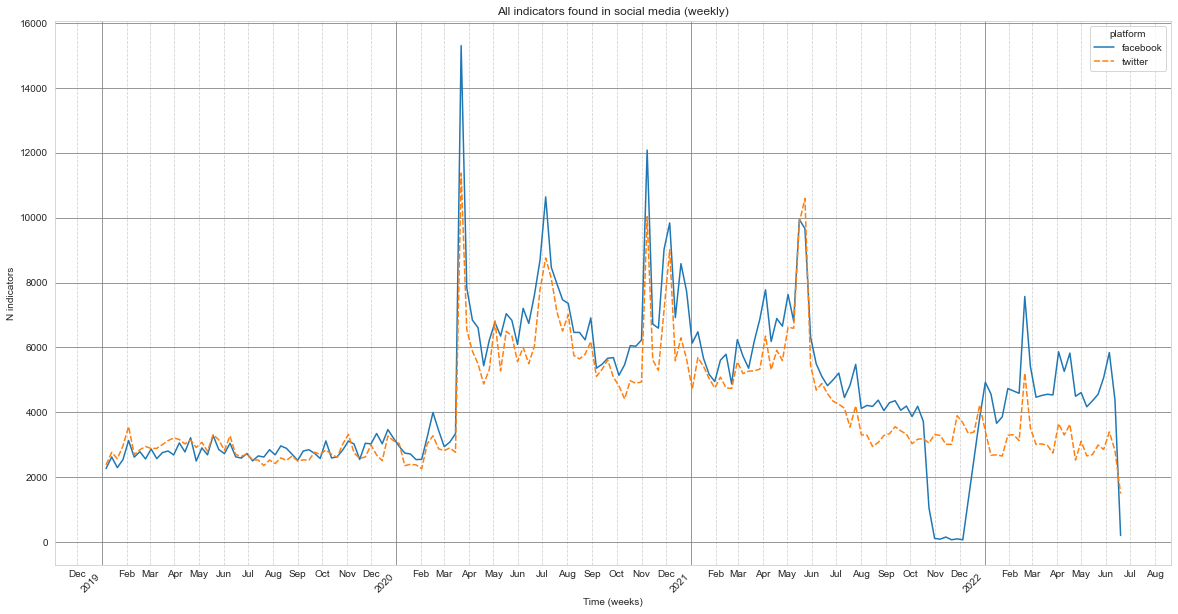

In [56]:
# all indicators
time_df = match_df.set_index(pd.DatetimeIndex(match_df['ts']))[['platform','indicator_code_merged']]

time_col_grouper = time_df.groupby([pd.Grouper(freq='1W'), 'platform'])
time_counts = time_col_grouper['platform'].count().to_frame('count')

plt.figure(figsize=(20,10))
sns.lineplot(data=time_counts, x="ts", y="count", hue="platform", style='platform')
plt.grid()

format_xaxis_month_year()

plt.title('All indicators found in social media (weekly)')
plt.ylabel('N indicators')
plt.xlabel('Time (weeks)')
plt.xticks(rotation=45, horizontalalignment='right')
#plt.show()
plt.savefig(socind_fold+'socmedia_indic-time_weekly.pdf')

> social_indic_by_time 1W
> social_indic_by_time 1D


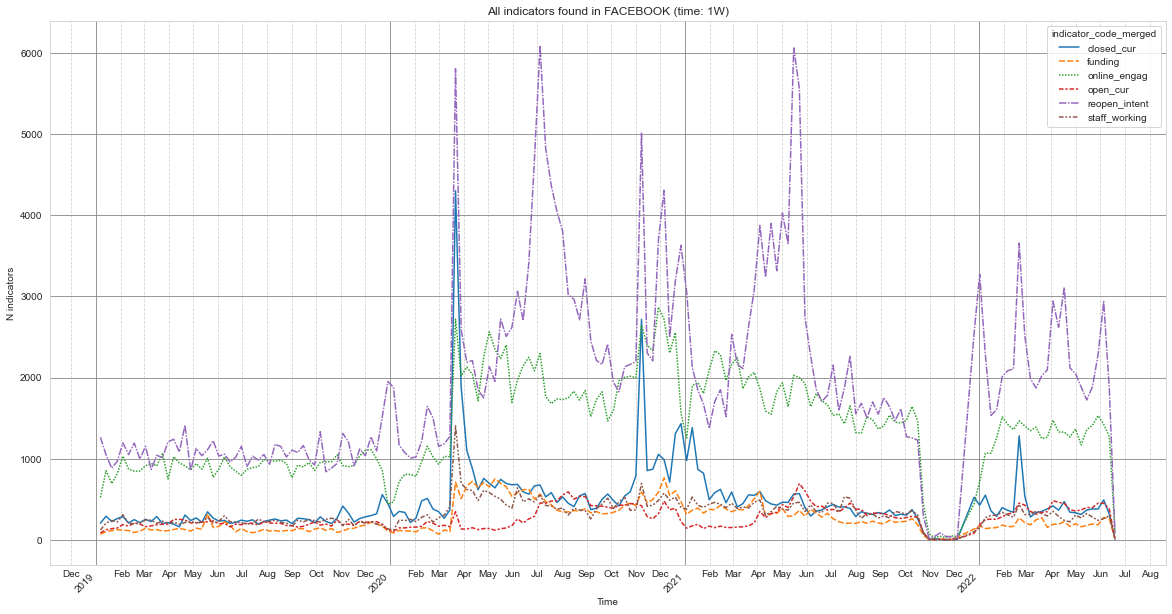

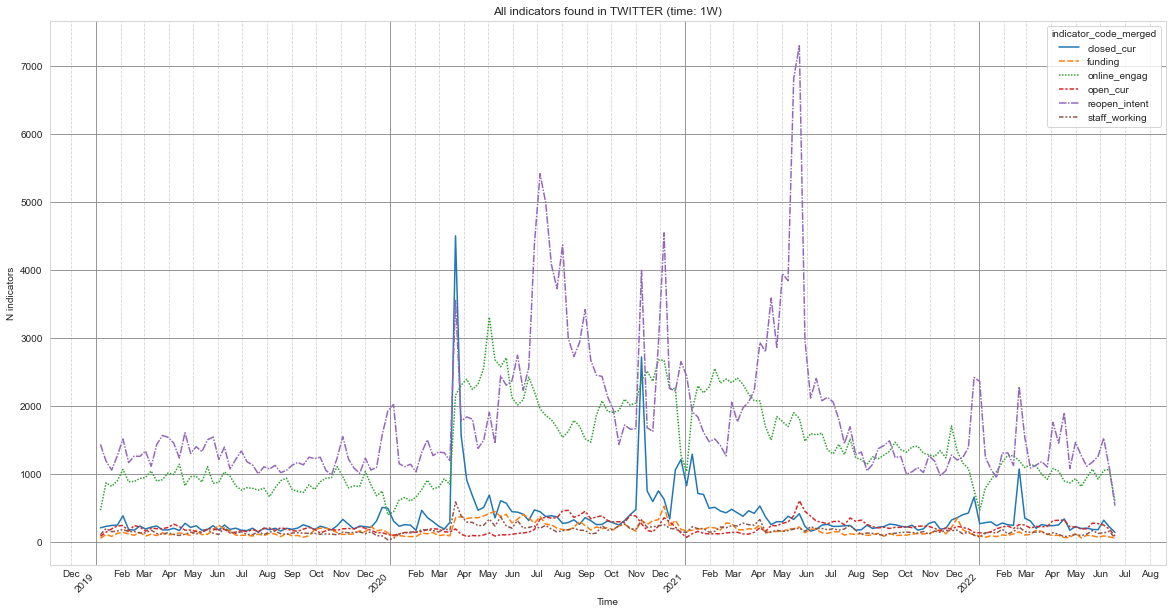

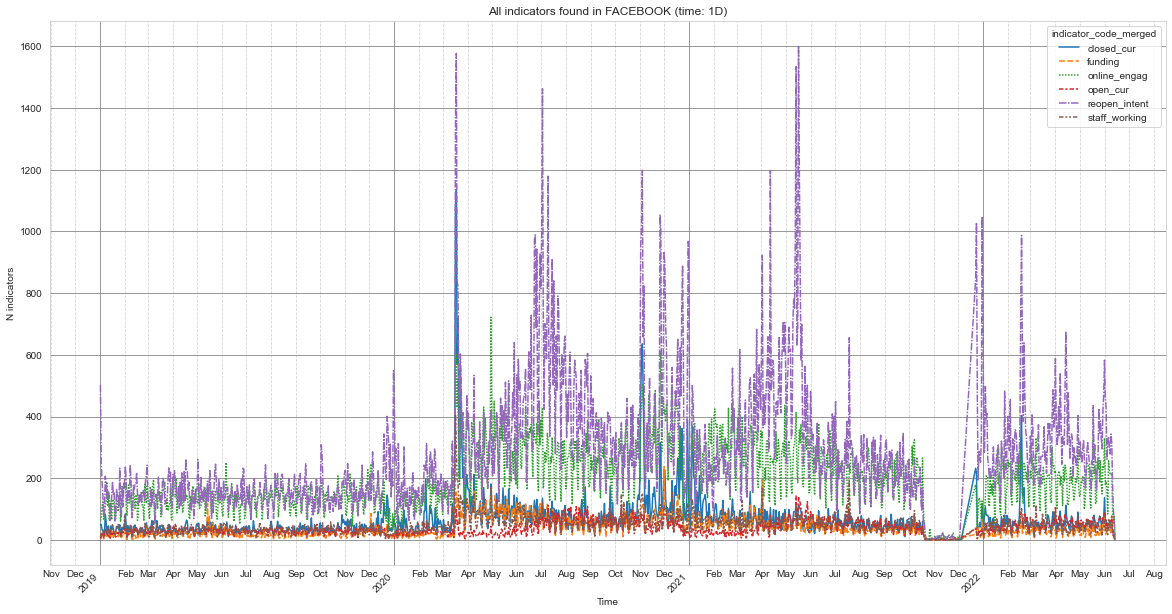

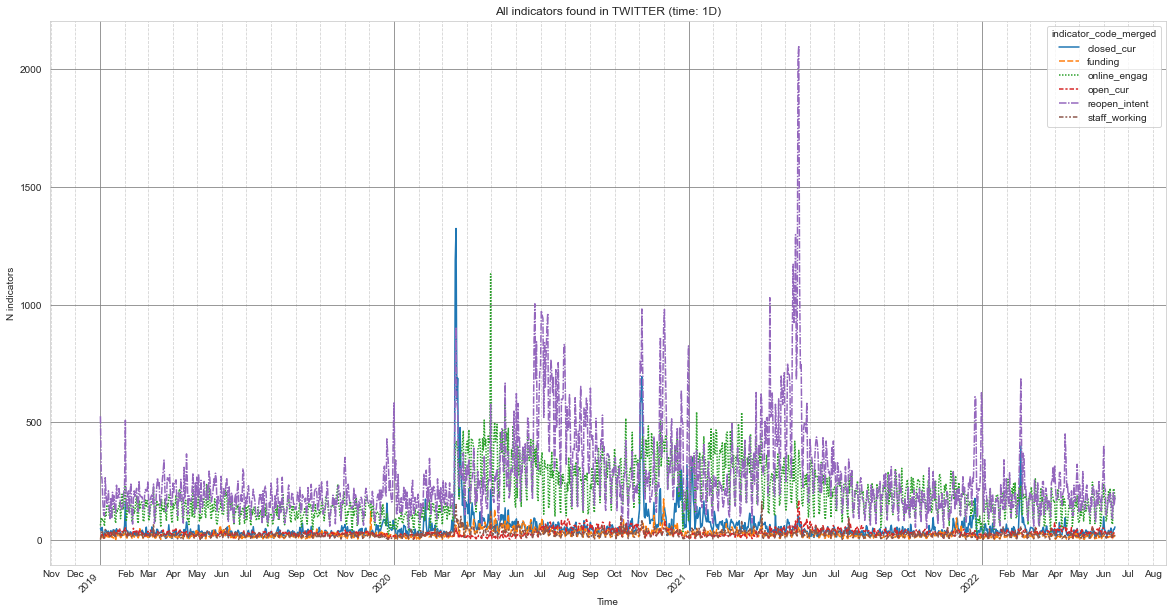

In [58]:
def an_social_indic_by_time(time_unit):
    print('> social_indic_by_time',time_unit)
    # by indicator
    for plat, time_group_df in time_df.groupby('platform'):
        # group data by time
        time_col_grouper = time_group_df.groupby([pd.Grouper(freq=time_unit), 'indicator_code_merged'])
        time_counts = time_col_grouper['indicator_code_merged'].count().to_frame('count')
        # save data
        data_df = pd.DataFrame(time_counts.to_records())
        data_df['ts'] = data_df['ts'].dt.tz_localize(None)
        data_df.to_excel(socind_fold+'socmedia_indic-time_weekly-{}-{}-data.xlsx'.format(plat,time_unit),index=False)
        # plot figure
        plt.figure(figsize=(20,10))
        sns.lineplot(data=time_counts, x="ts", y="count", hue="indicator_code_merged", style='indicator_code_merged')
        plt.title('All indicators found in {} (time: {})'.format(plat.upper(),time_unit))
        plt.ylabel('N indicators')
        plt.xlabel('Time')
        plt.grid()
        format_xaxis_month_year()
        plt.xticks(rotation=45, horizontalalignment='right')
        #plt.show()
        plt.savefig(socind_fold+'socmedia_indic-time_weekly-{}-{}.pdf'.format(plat,time_unit))
        
for time_u in ['1W','1D']:
    an_social_indic_by_time(time_u)

In [57]:
# TODO: find BAD DAYS
Weeks with low values:
2021-10-31 00:00:00
2021-11-07 00:00:00
2021-11-14 00:00:00
2021-11-21 00:00:00
2021-11-28 00:00:00
2021-12-05 00:00:00

SyntaxError: invalid syntax (431554124.py, line 28)

#### Temporal analysis by attributes

TODO

## Missing websites analysis

Analyse museums that do not show online activity

In [ ]:
fold = out_folder+'data/analysis/missing_web_soc_museums/'
for x in [fold]:
    print(x)
    if not os.path.exists(x):
        os.makedirs(x)
        
web_df = get_museums_w_web_urls(out_folder)[['muse_id','url','url_source']]
#web_df.columns
print(len(web_df))
attr_df = load_input_museums_wattributes(out_folder)
attr_df = get_extra_museum_attributes(attr_df)
print(len(attr_df))
web_df = web_df.merge(attr_df, on='muse_id', how='outer')
web_df = web_df.rename(columns={'muse_id':'museum_id'})
soc_df = get_twitter_facebook_links_v2(out_folder)[['museum_id','twitter_id','facebook_pages']]
web_df = web_df.merge(soc_df, on='museum_id', how='outer')
display(web_df.sample(10))

web_df.to_excel(fold+'museums_w_web_social_urls.xlsx', index=False)

del soc_df, attr_df

In [ ]:
# analyse missing links
print(web_df.url.value_counts())
web_df = web_df[web_df['url'] != 'closed']
web_df.url.value_counts()

web_df['url'].replace('no_resource', np.NaN, inplace=True)
web_df.url.value_counts()

web_df['b_web'] = ~web_df['url'].isnull()
display(web_df.sample(10))
web_df['b_web'].value_counts()

web_df['twitter_id'].value_counts()
web_df['b_twitter'] = web_df['twitter_id'] != 'no_resource'
web_df['b_twitter'].value_counts()
web_df['b_facebook'] = web_df['facebook_pages'] != 'no_resource'
web_df['b_facebook'].value_counts()

In [ ]:
web_df = web_df.rename(columns={'size':'m_size'})
res_df = []
for c in ['m_size','governance','governance_simpl','subject_matter_simpl','subject_matter','accreditation','region']:
    for var in ['b_web','b_twitter','b_facebook']:
        df = web_df.groupby([c,var], as_index=False).size()
        df['var1_name'] = c
        df['var2_name'] = var
        df = df.rename(columns={var:'var2_val'})
        df = df.rename(columns={c:'var1_val','size':'n_museums'})
        #print(df.columns)
        res_df.append(df)
res_df = pd.concat(res_df, ignore_index=True)[['var1_name','var1_val','var2_name','var2_val','n_museums']]
res_df.to_excel(fold+'missing_web_soc_museum_counts.xlsx', index=False)
res_df

In [ ]:
sum_df = res_df.groupby(['var1_name','var1_val','var2_name'], as_index=False).sum().rename(columns={'n_museums':'tot_museums'})
web_res_df = res_df.merge(sum_df[['var1_name','var1_val','var2_name','tot_museums']], on=['var1_name','var1_val','var2_name'], how='outer')
web_res_df['museum_pc'] = round(100*web_res_df['n_museums']/web_res_df['tot_museums'],1)
web_res_df[~web_res_df.var2_val].to_excel(fold+'missing_web_soc_museum_pc.xlsx', index=False)
display(web_res_df)

In [ ]:
wide_df = web_res_df[~web_res_df.var2_val].pivot(index=['var1_name','var1_val'], columns='var2_name', values='museum_pc').reset_index()
wide_df = wide_df.fillna(0).merge(web_res_df[['var1_val','var1_name','tot_museums']], on=['var1_val','var1_name']).drop_duplicates()
wide_df.to_excel(fold+'missing_web_soc_museum_wide_pc.xlsx', index=False)
wide_df

In [ ]:
df = web_res_df[~web_res_df.var2_val]
for var in ['b_facebook','b_twitter','b_web']:
    plt.figure(figsize=(12,22))
    p = sns.barplot(data=df[df.var2_name==var].sort_values(['var1_name','museum_pc'], ascending=False), 
                x='museum_pc', y='var1_val')
    plt.title("Museum without {} (%)".format(var.replace('b_','').replace('web','website')))
    plt.tight_layout()
    plt.savefig(fold+'missing_web_soc_museum-barchart-{}.pdf'.format(var))
    plt.clf()

## Website size analysis

Analyse numer of pages and sizes and deltas of museum websites.

### Download data from DB

In [ ]:
sql = "select * from analytics.website_sizes;"
websz_df = pd.read_sql(sql, db_conn)
websz_df = websz_df.drop(columns='index')
print(len(websz_df))
display(websz_df.sample(5))

#for c in ['page_text_words', 'html_page_content_length', 'sum_links_words','links_level1']:
#    websz_df[c] = df[c].fillna(0)

print("Museums N:",websz_df.museum_id.nunique())
print("Sessions N:",websz_df.session_id.nunique())

sz_fold = out_folder + 'data/analysis/website_sizes/'
print(sz_fold)
if not os.path.exists(sz_fold): os.makedirs(sz_fold)
if not os.path.exists(sz_fold+'websize_attribute_barcharts'): os.makedirs(sz_fold+'websize_attribute_barcharts')

websz_df.to_excel(sz_fold+'website_sizes.xlsx', index=False)

In [ ]:
doc_str = """
Analysis of size of museum websites:

10 snapshots are considered.

* website_size_by_attribute-mean.xlsx: mean of web sizes by museum attributes

Fields:
* page_text_len: length of plain text in the main web page (n characters)
* page_text_words: number of words in plain text in the main web page
* page_html_len: length of HTML code in the main web page (n characters)
* links_level1: number of links in the main page
* sum_links_length: sum of lenghts of plain text pages linked from main page (n characters)
* sum_links_words: sum of lenghts plain text pages linked from main page (n of words)
"""
write_file(doc_str, sz_fold+'data_dictionary-website_sizes.txt')

### Viz sizes

In [ ]:
websz_df.page_html_len.hist(bins=30)
plt.xlabel('HTML page length')
plt.ylabel('N museums')

In [ ]:
websz_df.page_html_len.hist(bins=30, log=True)
plt.xlabel('HTML page length')
plt.ylabel('N museums (log)')

In [ ]:
websz_df.links_level1.hist(bins=30)
plt.xlabel('Links N')
plt.ylabel('N museums')

In [ ]:
websz_df.links_level1.hist(bins=30, log=True)
plt.xlabel('Links N')
plt.ylabel('N museums (log)')

In [ ]:
# TODO: too many museums
for col in ['page_text_words', 'page_html_len', 'sum_links_words','links_level1']:
    g = sns.FacetGrid(websz_df.sample(10), col='museum_name', col_wrap=4)
    g.map_dataframe(sns.lineplot, x="session_time", y=col) #, hue=group_var, style=group_var, marker='.')
    g.add_legend() #loc='lower right')
    #[ax.set(ylabel='') for ax in g.axes.flat]
    [plt.setp(ax.get_xticklabels(), rotation=45, ha='right') for ax in g.axes.flat]
    fn = '{}website_sizes-by_museum-{}.pdf'.format(sz_fold, col)
    plt.savefig(fn,bbox_inches='tight')
    plt.clf()
    print(fn)

### Sizes by groups

In [ ]:
# get museum attributes
attr_df = get_extra_museum_attributes(load_input_museums_wattributes(out_folder))
webdf = get_museums_w_web_urls(out_folder)[['muse_id','url']]

attr_df = attr_df.merge(webdf, on='muse_id')
websz_att_df = pd.merge(websz_df, attr_df, left_on='museum_id', right_on='muse_id', how='left')

print(websz_att_df.columns)

# Summary of sizes per museum
websz_mus_df = websz_df.groupby('museum_id',as_index=False).mean().round(1).drop(columns=['page_id'])
websz_mus_df = pd.merge(websz_mus_df, attr_df, left_on='museum_id', right_on='muse_id', how='left')
for field in ['page_text_words','page_html_len','links_level1','sum_links_length','sum_links_words']:
    websz_mus_df[field+'_z'] = round((websz_mus_df[field] - websz_mus_df[field].mean())/websz_mus_df[field].std(),3)
        
websz_mus_df.to_excel(sz_fold+'website_size_by_museum-mean.xlsx', index=False)
print(len(websz_mus_df))
websz_mus_df

In [ ]:
def websize_stat(stat):
    # group by categories
    df = pd.DataFrame()
    for v in ['governance','governance_simpl','size','subject_matter_simpl','region','accreditation']:
        if stat == 'mean':
            meandf = websz_att_df.groupby(v, as_index=False).mean().round(1)
        if stat == 'std':
            meandf = websz_att_df.groupby(v, as_index=False).std().round(1)
        meandf['val'] = v + ' > ' + meandf[v]
        meandf['var'] = v
        meandf = meandf.drop(columns=[v,'page_id','deprivation_index'])
        # get z scores
        for field in meandf.columns.drop(['val','var']):
            meandf[field+'_z'] = round((meandf[field] - meandf[field].mean())/meandf[field].std(),3)
            
            # plots
            ax = sns.barplot(x=field, y=v, data=websz_att_df)
            fn = "{}/websize_attribute_barcharts/websize_barchart-{}-{}.pdf".format(sz_fold,v,field)
            plt.title('Analysis of website sizes by {} ({})'.format(v, stat))
            plt.tight_layout()
            plt.savefig(fn)
            plt.clf()
            
        # change col order    
        col = meandf.pop("val")
        meandf.insert(0, col.name, col)
        col = meandf.pop("var")
        meandf.insert(0, col.name, col)
        df = df.append(meandf)
    
    df.to_excel(sz_fold+'website_size_by_attribute-{}.xlsx'.format(stat),index=False)
    df

websize_stat('mean')
websize_stat('std')

In [ ]:
# TODO: check zero cases

13/160*100

End of notebook.